In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
path="/content/drive/MyDrive/Research/cods_comad_plots/SDC/dataset_1/"

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Generate dataset

In [4]:
y = np.random.randint(0,3,500)
idx= []
for i in range(3):
    print(i,sum(y==i))
    idx.append(y==i)

0 173
1 173
2 154


In [5]:
x = np.zeros((500,))

In [6]:
np.random.seed(12)
x[idx[0]] = np.random.uniform(low =-1,high =0,size= sum(idx[0]))
x[idx[1]] = np.random.uniform(low =0,high =1,size= sum(idx[1]))
x[idx[2]] = np.random.uniform(low =2,high =3,size= sum(idx[2]))

In [7]:
x[idx[0]][0], x[idx[2]][5] 

(-0.8458371576203276, 2.652362264031975)

In [8]:
print(x.shape,y.shape)

(500,) (500,)


In [9]:
idx= []
for i in range(3):
  idx.append(y==i)

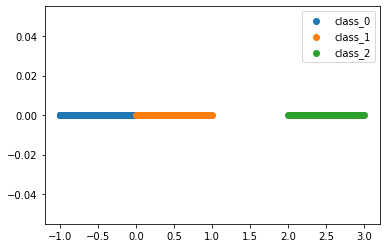

In [10]:
for i in range(3):
    y= np.zeros(x[idx[i]].shape[0])
    plt.scatter(x[idx[i]],y,label="class_"+str(i))
plt.legend()

In [11]:
bg_idx = [ np.where(idx[2] == True)[0]]

bg_idx = np.concatenate(bg_idx, axis = 0)
bg_idx.shape

(154,)

In [12]:
np.unique(bg_idx).shape

(154,)

In [13]:
x = x - np.mean(x[bg_idx], axis = 0, keepdims = True)


In [14]:
np.mean(x[bg_idx], axis = 0, keepdims = True), np.mean(x, axis = 0, keepdims = True)

(array([5.96925107e-16]), array([-1.76079542]))

In [15]:
x = x/np.std(x[bg_idx], axis = 0, keepdims = True)

In [16]:
np.std(x[bg_idx], axis = 0, keepdims = True), np.std(x, axis = 0, keepdims = True)

(array([1.]), array([4.32376018]))

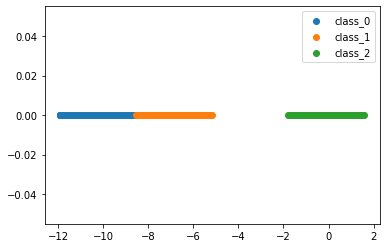

In [17]:
for i in range(3):
    y= np.zeros(x[idx[i]].shape[0])
    plt.scatter(x[idx[i]],y,label="class_"+str(i))
plt.legend()

In [18]:
foreground_classes = {'class_0','class_1' }

background_classes = {'class_2'}

In [19]:
fg_class  = np.random.randint(0,2)
fg_idx = np.random.randint(0,9)

a = []
for i in range(9):
    if i == fg_idx:
        b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
        a.append(x[b])
        print("foreground "+str(fg_class)+" present at " + str(fg_idx))
    else:
        bg_class = np.random.randint(2,3)
        b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
        a.append(x[b])
        print("background "+str(bg_class)+" present at " + str(i))
a = np.concatenate(a,axis=0)
print(a.shape)

print(fg_class , fg_idx)

background 2 present at 0
background 2 present at 1
background 2 present at 2
background 2 present at 3
background 2 present at 4
background 2 present at 5
background 2 present at 6
background 2 present at 7
foreground 1 present at 8
(9,)
1 8


In [20]:
a.shape

(9,)

In [21]:
np.reshape(a,(9,1))

array([[ 1.37337769],
       [ 0.95862311],
       [-0.46020342],
       [-0.83815419],
       [ 1.11032054],
       [ 1.17875096],
       [ 0.15176552],
       [ 1.11032054],
       [-5.92653481]])

In [22]:
a=np.reshape(a,(3,3))

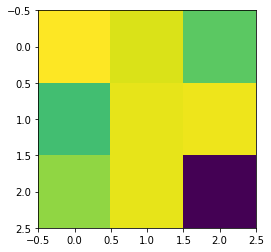

In [23]:
plt.imshow(a)

In [24]:
desired_num = 2000
mosaic_list_of_images =[]
mosaic_label = []
fore_idx=[]
for j in range(desired_num):
    np.random.seed(j)
    fg_class  = np.random.randint(0,2)
    fg_idx = np.random.randint(0,9)
    a = []
    for i in range(9):
        if i == fg_idx:
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            bg_class = np.random.randint(2,3)
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list_of_images.append(np.reshape(a,(9,1)))
    mosaic_label.append(fg_class)
    fore_idx.append(fg_idx)

In [25]:
mosaic_list_of_images = np.concatenate(mosaic_list_of_images,axis=1).T


In [26]:
mosaic_list_of_images.shape, mosaic_list_of_images[0]

((2000, 9), array([ -0.19914287,  -0.40007008,   1.17875096,   1.37001379,
          0.1077745 , -10.8404474 ,   0.19345192,   1.36393897,
         -1.30875302]))

In [27]:
for j in range(9):
  print(mosaic_list_of_images[0][j])
  

-0.19914286686163277
-0.4000700817648633
1.1787509590068428
1.3700137892000297
0.10777449912050141
-10.840447399356693
0.19345192491314023
1.3639389674787383
-1.308753024146608


In [28]:
mosaic_list_of_images_reshaped = np.reshape(mosaic_list_of_images, (2000,9,1))
mean_train = np.mean(mosaic_list_of_images_reshaped[0:1000], axis=0, keepdims= True)
print(mean_train.shape, mean_train)
std_train = np.std(mosaic_list_of_images_reshaped[0:1000], axis=0, keepdims= True)
print(std_train.shape, std_train)



(1, 9, 1) [[[-1.07252504]
  [-0.97996842]
  [-0.90467253]
  [-1.06811249]
  [-0.85460987]
  [-0.83599898]
  [-1.01166583]
  [-1.02731163]
  [-0.89550586]]]
(1, 9, 1) [[[3.0861819 ]
  [2.92446719]
  [2.9003667 ]
  [3.07849803]
  [2.80805251]
  [2.7655755 ]
  [2.9459505 ]
  [2.94745863]
  [2.73544141]]]


In [29]:
mosaic_list_of_images = ( mosaic_list_of_images_reshaped - mean_train ) / std_train

In [30]:
print(np.mean(mosaic_list_of_images[0:1000], axis=0, keepdims= True))

print(np.std(mosaic_list_of_images[0:1000], axis=0, keepdims= True))

[[[ 4.88498131e-17]
  [-7.10542736e-18]
  [ 0.00000000e+00]
  [-3.55271368e-18]
  [ 3.90798505e-17]
  [ 2.84217094e-17]
  [-5.24025268e-17]
  [-4.88498131e-17]
  [-3.55271368e-18]]]
[[[1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]]]


In [31]:
print(np.mean(mosaic_list_of_images[1000:2000], axis=0, keepdims= True))

print(np.std(mosaic_list_of_images[1000:2000], axis=0, keepdims= True))

[[[ 0.00761152]
  [-0.02000767]
  [-0.03239546]
  [-0.00857384]
  [ 0.02245144]
  [-0.00776563]
  [ 0.03948941]
  [ 0.01536153]
  [ 0.03931008]]]
[[[1.00882259]
  [1.05220767]
  [1.07372526]
  [0.98505595]
  [0.96792516]
  [1.03080031]
  [1.00193195]
  [1.01378938]
  [0.98408275]]]


In [32]:
mosaic_list_of_images = np.reshape(mosaic_list_of_images, (2000,9))

In [33]:
for j in range(9):
  print(mosaic_list_of_images[0][j])
  

0.28299763408955303
0.1982919634002554
0.7183310587574828
0.7919856547860872
0.3427230676059463
-3.6174924295818047
0.40907603566169237
0.8112923379247969
-0.15107147270691063


In [34]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]



In [35]:
batch = 250
msd1 = MosaicDataset(mosaic_list_of_images[0:1000], mosaic_label[0:1000] , fore_idx[0:1000])
train_loader = DataLoader( msd1 ,batch_size= batch ,shuffle=True)

In [36]:
batch = 250
msd2 = MosaicDataset(mosaic_list_of_images[1000:2000], mosaic_label[1000:2000] , fore_idx[1000:2000])
test_loader = DataLoader( msd2 ,batch_size= batch ,shuffle=True)

In [37]:
class Focus(nn.Module):
  def __init__(self):
    super(Focus, self).__init__()

    self.fc1 = nn.Linear(1, 1, bias=False)
    torch.nn.init.zeros_(self.fc1.weight)
    # self.fc2 = nn.Linear(2, 1)

  def forward(self,z):  #y is avg image #z batch of list of 9 images
    y = torch.zeros([batch], dtype=torch.float64)
    x = torch.zeros([batch,9],dtype=torch.float64)
    y = y.to("cuda")
    x = x.to("cuda")
    # print(x.shape, z.shape)
    for i in range(9):
      # print(z[:,i].shape)
      # print(self.helper(z[:,i])[:,0].shape)
      x[:,i] = self.helper(z[:,i])[:,0]
    # print(x.shape, z.shape)
    x = F.softmax(x,dim=1)
    # print(x.shape, z.shape)
    # x1 = x[:,0]
    # print(torch.mul(x[:,0],z[:,0]).shape)

    for i in range(9):            
      # x1 = x[:,i]          
      y = y + torch.mul(x[:,i],z[:,i])

    # print(x.shape, y.shape)
    return x, y
    
  def helper(self, x):
    x = x.view(-1, 1)
    # x = F.relu(self.fc1(x))
    x = (self.fc1(x))

    return x

In [38]:
class Classification(nn.Module):
  def __init__(self):
    super(Classification, self).__init__()
    self.fc1 = nn.Linear(1, 50)
    self.fc2 = nn.Linear(50, 10)
    self.fc3 = nn.Linear(10, 2)
    torch.nn.init.xavier_normal_(self.fc1.weight)
    torch.nn.init.zeros_(self.fc1.bias)
    torch.nn.init.xavier_normal_(self.fc2.weight)
    torch.nn.init.zeros_(self.fc2.bias)
    torch.nn.init.xavier_normal_(self.fc3.weight)
    torch.nn.init.zeros_(self.fc3.bias)


  def forward(self, x):
    x = x.view(-1, 1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = (self.fc3(x))
    return x

In [39]:
# test_images =[]        #list of mosaic images, each mosaic image is saved as laist of 9 images
# fore_idx_test =[]                   #list of indexes at which foreground image is present in a mosaic image                
# test_label=[]                # label of mosaic image = foreground class present in that mosaic
# for i in range(10000):
#   bg_idx = np.random.randint(0,47335,8)
#   fg_idx = np.random.randint(0,12665)
#   fg = np.random.randint(0,9)
#   fore_idx_test.append(fg)
#   image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
#   test_images.append(image_list)
#   test_label.append(label)

In [40]:
torch.manual_seed(12)
focus_net = Focus().double()
focus_net = focus_net.to("cuda")

In [41]:
torch.manual_seed(12)
classify = Classification().double()
classify = classify.to("cuda")

In [42]:
focus_net.fc1.weight, focus_net.fc1.weight.shape

(Parameter containing:
 tensor([[0.]], device='cuda:0', dtype=torch.float64, requires_grad=True),
 torch.Size([1, 1]))

In [43]:
classify.fc1.weight, classify.fc1.bias, classify.fc1.weight.shape

(Parameter containing:
 tensor([[ 0.0167],
         [-0.3945],
         [-0.1101],
         [ 0.3760],
         [-0.2691],
         [-0.0475],
         [ 0.1475],
         [-0.0451],
         [-0.1766],
         [ 0.0345],
         [-0.0474],
         [-0.1443],
         [ 0.1473],
         [ 0.2130],
         [ 0.1529],
         [-0.0771],
         [ 0.4276],
         [-0.0421],
         [-0.1185],
         [-0.2604],
         [-0.3282],
         [ 0.2025],
         [-0.4305],
         [ 0.1285],
         [ 0.1706],
         [-0.1513],
         [ 0.0023],
         [-0.2234],
         [-0.2057],
         [ 0.0482],
         [ 0.0546],
         [ 0.1859],
         [-0.2723],
         [-0.0513],
         [ 0.0089],
         [-0.0849],
         [-0.1263],
         [-0.1122],
         [-0.1499],
         [ 0.0398],
         [-0.0070],
         [-0.1511],
         [ 0.2758],
         [-0.2683],
         [ 0.5113],
         [ 0.1282],
         [ 0.0423],
         [-0.1871],
         [ 0.1577

In [44]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer_classify = optim.Adam(classify.parameters(), lr=0.01 ) #, momentum=0.9)
optimizer_focus = optim.Adam(focus_net.parameters(), lr=0.01 ) #, momentum=0.9)

In [45]:
col1=[]
col2=[]
col3=[]
col4=[]
col5=[]
col6=[]
col7=[]
col8=[]
col9=[]
col10=[]
col11=[]
col12=[]
col13=[]

In [46]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in train_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)
    # print(outputs.shape)
    _, predicted = torch.max(outputs.data, 1)
    # print(predicted.shape)

    for j in range(labels.size(0)):
      count += 1
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      # print(focus, fore_idx[j], predicted[j])
      if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 1000 train images: %d %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true %d =============> FTPT : %d %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %d %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %d %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %d %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )

print("argmax_more_than_half ==================> ",argmax_more_than_half)
print("argmax_less_than_half ==================> ",argmax_less_than_half)
print(count)

print("="*100)

col1.append(0)
col2.append(argmax_more_than_half)
col3.append(argmax_less_than_half)
col4.append(focus_true_pred_true)
col5.append(focus_false_pred_true)
col6.append(focus_true_pred_false)
col7.append(focus_false_pred_false)

Accuracy of the network on the 1000 train images: 31 %
total correct 313
total train set images 1000
focus_true_pred_true 45 =============> FTPT : 4 %
focus_false_pred_true 268 =============> FFPT : 26 %
focus_true_pred_false 74 =============> FTPF : 7 %
focus_false_pred_false 613 =============> FFPF : 61 %
argmax_more_than_half ==================>  0
argmax_less_than_half ==================>  1000
1000


In [47]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)

    for j in range(labels.size(0)):
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 1000 test images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true %d =============> FTPT : %d %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %d %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %d %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %d %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )

print("argmax_more_than_half ==================> ",argmax_more_than_half)
print("argmax_less_than_half ==================> ",argmax_less_than_half)
col8.append(argmax_more_than_half)
col9.append(argmax_less_than_half)
col10.append(focus_true_pred_true)
col11.append(focus_false_pred_true)
col12.append(focus_true_pred_false)
col13.append(focus_false_pred_false)

Accuracy of the network on the 1000 test images: 27 %
total correct 278
total train set images 1000
focus_true_pred_true 41 =============> FTPT : 4 %
focus_false_pred_true 237 =============> FFPT : 23 %
focus_true_pred_false 81 =============> FTPF : 8 %
focus_false_pred_false 641 =============> FFPF : 64 %
argmax_more_than_half ==================>  0
argmax_less_than_half ==================>  1000


In [48]:
nos_epochs = 1000
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0


for epoch in range(nos_epochs):  # loop over the dataset multiple times

  focus_true_pred_true =0
  focus_false_pred_true =0
  focus_true_pred_false =0
  focus_false_pred_false =0
  
  argmax_more_than_half = 0
  argmax_less_than_half =0
  
  running_loss = 0.0
  epoch_loss = []
  cnt=0

  iteration = desired_num // batch
  
  #training data set
  
  for i, data in  enumerate(train_loader):
    inputs , labels , fore_idx = data
    inputs, labels = inputs.to("cuda"), labels.to("cuda")
    inputs = inputs.double()
    # zero the parameter gradients
    
    optimizer_focus.zero_grad()
    optimizer_classify.zero_grad()
    
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)
#     print(outputs)
#     print(outputs.shape,labels.shape , torch.argmax(outputs, dim=1))

    loss = criterion(outputs, labels) 
    loss.backward()
    optimizer_focus.step()
    optimizer_classify.step()

    running_loss += loss.item()
    mini = 3
    if cnt % mini == mini-1:    # print every 40 mini-batches
      print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, running_loss / mini))
      epoch_loss.append(running_loss/mini)
      running_loss = 0.0
    cnt=cnt+1
    
    if epoch % 5 == 0:
      for j in range (batch):
        focus = torch.argmax(alphas[j])

        if(alphas[j][focus] >= 0.5):
          argmax_more_than_half +=1
        else:
          argmax_less_than_half +=1

        if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1

        elif(focus != fore_idx[j] and predicted[j] == labels[j]):
          focus_false_pred_true +=1

        elif(focus == fore_idx[j] and predicted[j] != labels[j]):
          focus_true_pred_false +=1

        elif(focus != fore_idx[j] and predicted[j] != labels[j]):
          focus_false_pred_false +=1

  if(np.mean(epoch_loss) <= 0.001):
      break;

  if epoch % 5 == 0:
    col1.append(epoch + 1)
    col2.append(argmax_more_than_half)
    col3.append(argmax_less_than_half)
    col4.append(focus_true_pred_true)
    col5.append(focus_false_pred_true)
    col6.append(focus_true_pred_false)
    col7.append(focus_false_pred_false)
    # print("="*20)
    # print("Train FTPT : ", col4)
    # print("Train FFPT : ", col5)
    #************************************************************************
    #testing data set  
    # focus_net.eval()
    with torch.no_grad():
      focus_true_pred_true =0
      focus_false_pred_true =0
      focus_true_pred_false =0
      focus_false_pred_false =0

      argmax_more_than_half = 0
      argmax_less_than_half =0
      for data in test_loader:
        inputs, labels , fore_idx = data
        inputs = inputs.double()
        inputs, labels = inputs.to("cuda"), labels.to("cuda")
        alphas, avg_images = focus_net(inputs)
        outputs = classify(avg_images)
        _, predicted = torch.max(outputs.data, 1)

        for j in range (batch):
          focus = torch.argmax(alphas[j])

          if(alphas[j][focus] >= 0.5):
            argmax_more_than_half +=1
          else:
            argmax_less_than_half +=1

          if(focus == fore_idx[j] and predicted[j] == labels[j]):
            focus_true_pred_true += 1

          elif(focus != fore_idx[j] and predicted[j] == labels[j]):
            focus_false_pred_true +=1

          elif(focus == fore_idx[j] and predicted[j] != labels[j]):
            focus_true_pred_false +=1

          elif(focus != fore_idx[j] and predicted[j] != labels[j]):
            focus_false_pred_false +=1
      
    col8.append(argmax_more_than_half)
    col9.append(argmax_less_than_half)
    col10.append(focus_true_pred_true)
    col11.append(focus_false_pred_true)
    col12.append(focus_true_pred_false)
    col13.append(focus_false_pred_false)
    # print("Test FTPT : ", col10)
    # print("Test FFPT : ", col11)
    # print("="*20)
    
print('Finished Training')

[1,     3] loss: 0.685
[2,     3] loss: 0.650
[3,     3] loss: 0.601
[4,     3] loss: 0.518
[5,     3] loss: 0.436
[6,     3] loss: 0.329
[7,     3] loss: 0.277
[8,     3] loss: 0.215
[9,     3] loss: 0.180
[10,     3] loss: 0.183
[11,     3] loss: 0.158
[12,     3] loss: 0.117
[13,     3] loss: 0.136
[14,     3] loss: 0.131
[15,     3] loss: 0.119
[16,     3] loss: 0.128
[17,     3] loss: 0.128
[18,     3] loss: 0.119
[19,     3] loss: 0.130
[20,     3] loss: 0.116
[21,     3] loss: 0.122
[22,     3] loss: 0.126
[23,     3] loss: 0.130
[24,     3] loss: 0.125
[25,     3] loss: 0.120
[26,     3] loss: 0.113
[27,     3] loss: 0.108
[28,     3] loss: 0.107
[29,     3] loss: 0.107
[30,     3] loss: 0.116
[31,     3] loss: 0.108
[32,     3] loss: 0.121
[33,     3] loss: 0.108
[34,     3] loss: 0.120
[35,     3] loss: 0.105
[36,     3] loss: 0.110
[37,     3] loss: 0.116
[38,     3] loss: 0.110
[39,     3] loss: 0.103
[40,     3] loss: 0.101
[41,     3] loss: 0.116
[42,     3] loss: 0.110
[

In [49]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()

In [50]:
columns = ["epochs", "argmax > 0.5" ,"argmax < 0.5", "focus_true_pred_true", "focus_false_pred_true", "focus_true_pred_false", "focus_false_pred_false" ]

In [51]:
df_train[columns[0]] = col1
df_train[columns[1]] = col2
df_train[columns[2]] = col3
df_train[columns[3]] = col4
df_train[columns[4]] = col5
df_train[columns[5]] = col6
df_train[columns[6]] = col7

df_test[columns[0]] = col1
df_test[columns[1]] = col8
df_test[columns[2]] = col9
df_test[columns[3]] = col10
df_test[columns[4]] = col11
df_test[columns[5]] = col12
df_test[columns[6]] = col13

In [52]:
df_train

,epochs,argmax > 0.5,argmax < 0.5,focus_true_pred_true,focus_false_pred_true,focus_true_pred_false,focus_false_pred_false
0,0,0,1000,45,268,74,613
1,1,0,1000,174,395,105,326
2,6,0,1000,873,0,127,0
3,11,0,1000,931,0,69,0
4,16,5,995,943,0,57,0
...,...,...,...,...,...,...,...
196,976,510,490,942,0,58,0
197,981,508,492,951,0,49,0
198,986,504,496,953,0,47,0
199,991,503,497,949,0,51,0


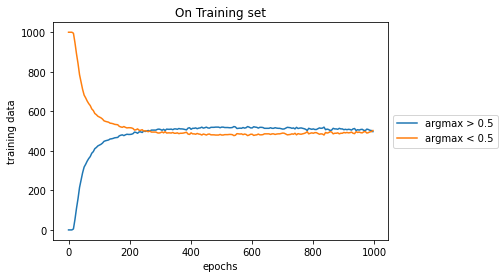

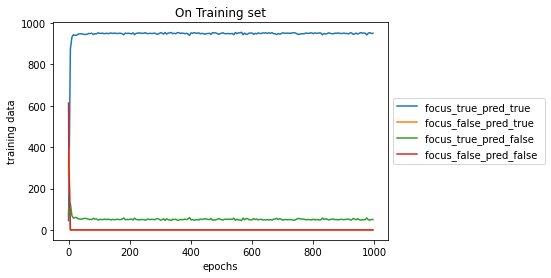

In [53]:
# plt.figure(12,12)
plt.plot(col1,col2, label='argmax > 0.5')
plt.plot(col1,col3, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.title("On Training set")
plt.show()

plt.plot(col1,col4, label ="focus_true_pred_true ")
plt.plot(col1,col5, label ="focus_false_pred_true ")
plt.plot(col1,col6, label ="focus_true_pred_false ")
plt.plot(col1,col7, label ="focus_false_pred_false ")
plt.title("On Training set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.show()

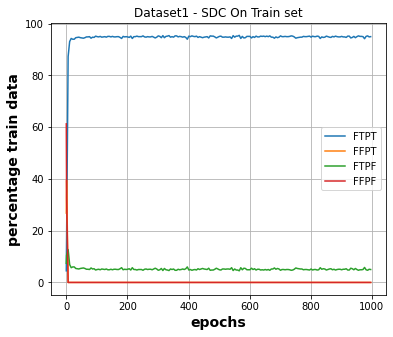

In [54]:
plt.figure(figsize=(6,5))
plt.plot(col1,np.array(col4)/10, label ="FTPT")
plt.plot(col1,np.array(col5)/10, label ="FFPT")
plt.plot(col1,np.array(col6)/10, label ="FTPF")
plt.plot(col1,np.array(col7)/10, label ="FFPF")
plt.title("Dataset1 - SDC On Train set")
plt.grid()
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend()
plt.xlabel("epochs", fontsize=14, fontweight = 'bold')
plt.ylabel("percentage train data", fontsize=14, fontweight = 'bold')
plt.savefig(path+"ds1_train.png", bbox_inches="tight")
plt.savefig(path+"ds1_train.pdf", bbox_inches="tight")
plt.savefig("ds1_train.png", bbox_inches="tight")
plt.savefig("ds1_train.pdf", bbox_inches="tight")
plt.show()

In [55]:
df_test

,epochs,argmax > 0.5,argmax < 0.5,focus_true_pred_true,focus_false_pred_true,focus_true_pred_false,focus_false_pred_false
0,0,0,1000,41,237,81,641
1,1,0,1000,691,0,309,0
2,6,0,1000,881,0,119,0
3,11,0,1000,935,0,65,0
4,16,7,993,936,0,64,0
...,...,...,...,...,...,...,...
196,976,537,463,934,0,66,0
197,981,541,459,939,0,61,0
198,986,537,463,944,0,56,0
199,991,534,466,943,0,57,0


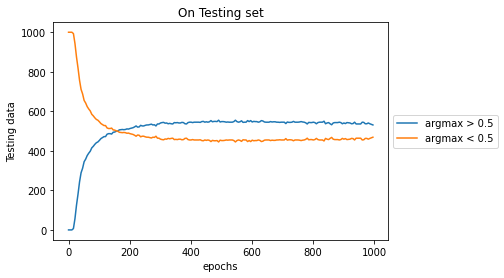

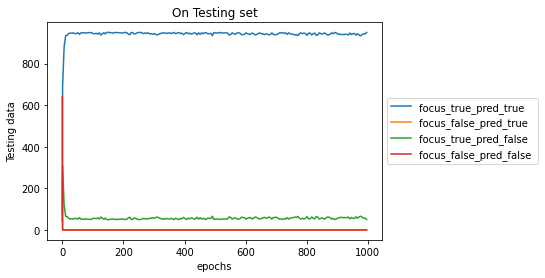

In [56]:
# plt.figure(12,12)
plt.plot(col1,col8, label='argmax > 0.5')
plt.plot(col1,col9, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("Testing data")
plt.title("On Testing set")
plt.show()

plt.plot(col1,col10, label ="focus_true_pred_true ")
plt.plot(col1,col11, label ="focus_false_pred_true ")
plt.plot(col1,col12, label ="focus_true_pred_false ")
plt.plot(col1,col13, label ="focus_false_pred_false ")
plt.title("On Testing set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("Testing data")
plt.show()

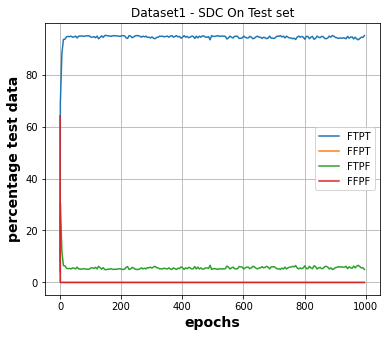

In [57]:
plt.figure(figsize=(6,5))
plt.plot(col1,np.array(col10)/10, label ="FTPT")
plt.plot(col1,np.array(col11)/10, label ="FFPT")
plt.plot(col1,np.array(col12)/10, label ="FTPF")
plt.plot(col1,np.array(col13)/10, label ="FFPF")
plt.title("Dataset1 - SDC On Test set")
plt.grid()
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend()
plt.xlabel("epochs", fontsize=14, fontweight = 'bold')
plt.ylabel("percentage test data", fontsize=14, fontweight = 'bold')
plt.savefig(path+"ds1_test.png", bbox_inches="tight")
plt.savefig(path+"ds1_test.pdf", bbox_inches="tight")
plt.savefig("ds1_test.png", bbox_inches="tight")
plt.savefig("ds1_test.pdf", bbox_inches="tight")
plt.show()

In [62]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in train_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)

    for j in range(labels.size(0)):
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 1000 train images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true %d =============> FTPT : %d %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %d %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %d %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %d %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )

print("argmax_more_than_half ==================> ",argmax_more_than_half)
print("argmax_less_than_half ==================> ",argmax_less_than_half)

Accuracy of the network on the 1000 train images: 94 %
total correct 945
total train set images 1000
focus_true_pred_true 945 =============> FTPT : 94 %
focus_false_pred_true 0 =============> FFPT : 0 %
focus_true_pred_false 55 =============> FTPF : 5 %
focus_false_pred_false 0 =============> FFPF : 0 %
argmax_more_than_half ==================>  513
argmax_less_than_half ==================>  487


In [63]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)

    for j in range(labels.size(0)):
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 1000 test images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true %d =============> FTPT : %d %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %d %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %d %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %d %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )

print("argmax_more_than_half ==================> ",argmax_more_than_half)
print("argmax_less_than_half ==================> ",argmax_less_than_half)

Accuracy of the network on the 1000 test images: 93 %
total correct 934
total train set images 1000
focus_true_pred_true 934 =============> FTPT : 93 %
focus_false_pred_true 0 =============> FFPT : 0 %
focus_true_pred_false 66 =============> FTPF : 6 %
focus_false_pred_false 0 =============> FFPF : 0 %
argmax_more_than_half ==================>  545
argmax_less_than_half ==================>  455


In [64]:
correct = 0
total = 0

with torch.no_grad():
  for data in train_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels = inputs.to("cuda"), labels.to("cuda")
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 1000 train images: %d %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

Accuracy of the network on the 1000 train images: 94 %
total correct 945
total train set images 1000


In [65]:
correct = 0
total = 0

with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels = inputs.to("cuda"), labels.to("cuda")
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 1000 test images: %d %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

Accuracy of the network on the 1000 test images: 93 %
total correct 934
total train set images 1000
